# Import Packages

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load the data

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Top 5 rows

In [3]:
print(customers.head())
print("----------------------------------------------------------------------")
print(transactions.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
----------------------------------------------------------------------
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68 

# Check the Missing value

In [4]:
print(customers.isnull().sum())
print(transactions.isnull().sum())

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


# Convert date columns to datetime format

In [5]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Feature Engineering

In [6]:
agg_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],  
    'Quantity': 'sum',             
    'ProductID': 'nunique',        
    'TransactionDate': 'max'    
}).reset_index()

# Rename columns for clarity
agg_transactions.columns = ['CustomerID', 'TotalSpend', 'AvgSpend', 'TotalQuantity', 'UniqueProducts', 'LastTransaction']

# Calculate recency (days since last transaction)
agg_transactions['Recency'] = (pd.Timestamp.today() - agg_transactions['LastTransaction']).dt.days

# Merge aggregated data with customers dataset
customer_data = pd.merge(customers, agg_transactions, on='CustomerID', how='inner')

# Drop unnecessary columns
customer_data.drop(['LastTransaction', 'CustomerName'], axis=1, inplace=True)

# Encode categorical variables like Region
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

print(customer_data.head())

  CustomerID SignupDate  TotalSpend  AvgSpend  TotalQuantity  UniqueProducts  \
0      C0001 2022-07-10     3354.52   670.904             12               5   
1      C0002 2022-02-13     1862.74   465.685             10               4   
2      C0003 2024-03-07     2725.38   681.345             14               4   
3      C0004 2022-10-09     5354.88   669.360             23               8   
4      C0005 2022-08-15     2034.24   678.080              7               3   

   Recency  Region_Europe  Region_North America  Region_South America  
0       85          False                 False                  True  
1       55          False                 False                 False  
2      155          False                 False                  True  
3       34          False                 False                  True  
4       84          False                 False                 False  


# Data Scaling

In [7]:
# Select numerical features for scaling
features = ['TotalSpend', 'AvgSpend', 'TotalQuantity', 'UniqueProducts', 'Recency']
scaler = StandardScaler()
customer_data_scaled = customer_data.copy()

# Scale the numerical features
customer_data_scaled[features] = scaler.fit_transform(customer_data[features])

print(customer_data_scaled.head())

  CustomerID SignupDate  TotalSpend  AvgSpend  TotalQuantity  UniqueProducts  \
0      C0001 2022-07-10   -0.061701 -0.070263      -0.122033        0.050047   
1      C0002 2022-02-13   -0.877744 -0.934933      -0.448000       -0.424204   
2      C0003 2024-03-07   -0.405857 -0.026271       0.203934       -0.424204   
3      C0004 2022-10-09    1.032547 -0.076769       1.670787        1.472798   
4      C0005 2022-08-15   -0.783929 -0.040028      -0.936951       -0.898455   

    Recency  Region_Europe  Region_North America  Region_South America  
0 -0.266992          False                 False                  True  
1 -0.690913          False                 False                 False  
2  0.722157          False                 False                  True  
3 -0.987658          False                 False                  True  
4 -0.281123          False                 False                 False  


# Algorithms

In [13]:
n_clusters_range = range(2, 10)
db_scores = []
silhouette_scores = []

for n_clusters in n_clusters_range:
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(customer_data_scaled[features])
    
    # Predict cluster labels
    labels = kmeans.labels_
    
    # Calculate metrics
    db_scores.append(davies_bouldin_score(customer_data_scaled[features], labels))
    silhouette_scores.append(silhouette_score(customer_data_scaled[features], labels))
print("Other relevant clustering metrics score:")
print("------------------------------------------")
print("DB Scores:", db_scores)
print("-----------------------------------------------------------------------------------------------------")
print("Silhouette Scores:", silhouette_scores)

Other relevant clustering metrics score:
------------------------------------------
DB Scores: [1.1441635667601464, 1.2033639863059247, 1.0872767889706099, 1.199358645616652, 1.2943541629739004, 1.1957670850909616, 1.1770142369408996, 1.2453066895065925]
-----------------------------------------------------------------------------------------------------
Silhouette Scores: [0.3192956583967212, 0.29778991566028556, 0.30585837758607126, 0.25739413871871536, 0.2360536433587954, 0.2525134107402438, 0.2395162534131269, 0.21241964662461627]


# Model Training

In [9]:
optimal_clusters = n_clusters_range[db_scores.index(min(db_scores))]
print(f"Optimal number of clusters: {optimal_clusters}")
print("------------------------------------------------------------------")

# Train the final KMeans model
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_final.fit(customer_data_scaled[features])

# Add cluster labels to the dataset
customer_data['Cluster'] = kmeans_final.labels_
print(customer_data.head())

Optimal number of clusters: 4
------------------------------------------------------------------
  CustomerID SignupDate  TotalSpend  AvgSpend  TotalQuantity  UniqueProducts  \
0      C0001 2022-07-10     3354.52   670.904             12               5   
1      C0002 2022-02-13     1862.74   465.685             10               4   
2      C0003 2024-03-07     2725.38   681.345             14               4   
3      C0004 2022-10-09     5354.88   669.360             23               8   
4      C0005 2022-08-15     2034.24   678.080              7               3   

   Recency  Region_Europe  Region_North America  Region_South America  Cluster  
0       85          False                 False                  True        2  
1       55          False                 False                 False        2  
2      155          False                 False                  True        2  
3       34          False                 False                  True        0  
4       84       

# Cluster Visualization and Evaluation Criteria

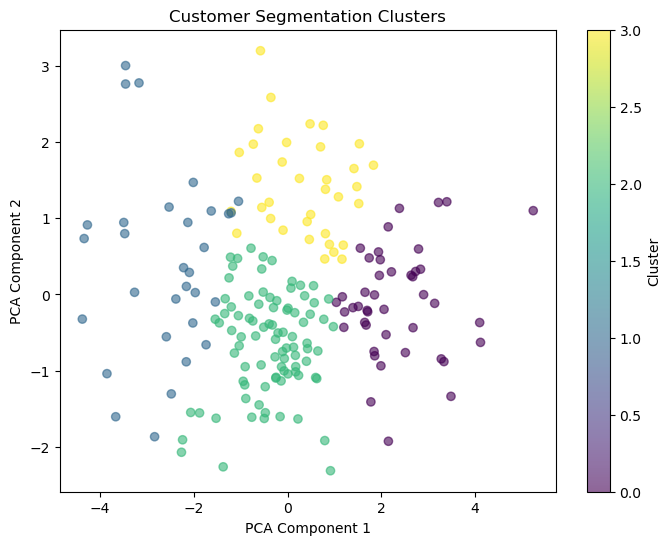

In [10]:
#Use PCA to reduce dimensionality and visualize clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_data_scaled[features])

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=customer_data['Cluster'], cmap='viridis', alpha=0.6)
plt.title('Customer Segmentation Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# DB index value

In [11]:
final_db_index = davies_bouldin_score(customer_data_scaled[features], kmeans_final.labels_)
print(f"Final DB Index: {final_db_index}")

Final DB Index: 1.0872767889706099
